In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import reg_utils    #第二部分，正则化
import gc_utils     #第三部分，梯度校验
#%matplotlib inline #如果你使用的是Jupyter Notebook，请取消注释。
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

D:\programming\项目\tensorflow\Course 2 - 改善深层神经网络01习题\reg_utils.py:65: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
D:\programming\项目\tensorflow\Course 2 - 改善深层神经网络01习题\reg_utils.py:66: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


读取并绘制数据集

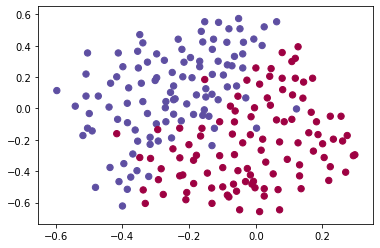

In [2]:
train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot=True)

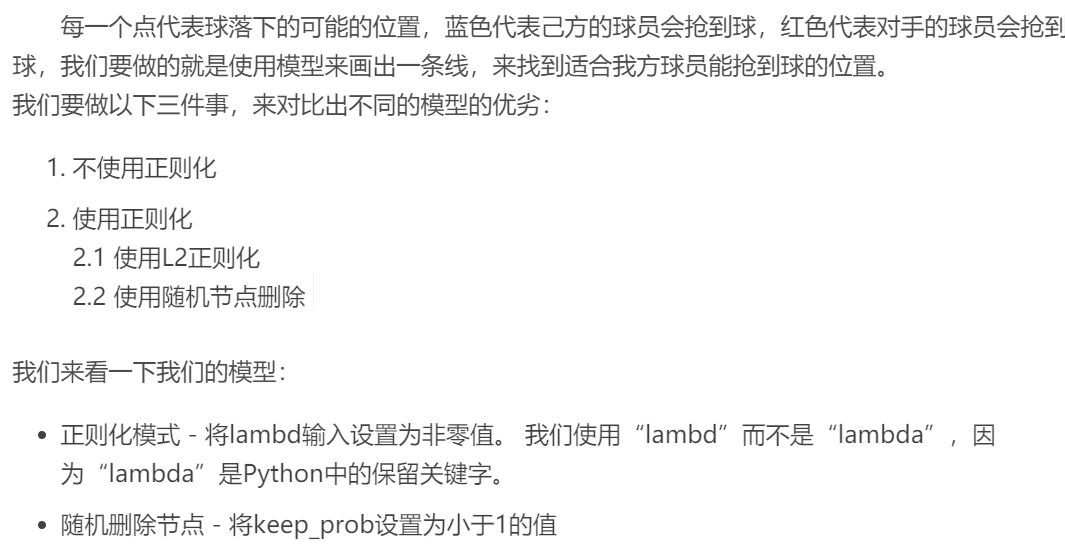

In [3]:
def model(X,Y,learning_rate=0.3,num_iterations=30000,print_cost=True,is_plot=True,lambd=0,keep_prob=1):
    """
    实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

    参数：
        X - 输入的数据，维度为(2, 要训练/测试的数量)
        Y - 标签，【0(蓝色) | 1(红色)】，维度为(1，对应的是输入的数据的标签)
        learning_rate - 学习速率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每迭代10000次打印一次，但是每1000次记录一个成本值
        is_polt - 是否绘制梯度下降的曲线图
        lambd - 正则化的超参数，实数
        keep_prob - 随机删除节点的概率
    返回
        parameters - 学习后的参数
    """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]

    #初始化参数
    parameters = reg_utils.initialize_parameters(layers_dims)

    #开始学习
    for i in range(0,num_iterations):
        #前向传播
        ##是否随机删除节点
        if keep_prob == 1:
            ###不随机删除节点
            a3 , cache = reg_utils.forward_propagation(X,parameters)
        elif keep_prob < 1:
            ###随机删除节点
            a3 , cache = forward_propagation_with_dropout(X,parameters,keep_prob)
        else:
            print("keep_prob参数错误！程序退出。")
            exit

        #计算成本
        ## 是否使用二范数
        if lambd == 0:
            ###不使用L2正则化
            cost = reg_utils.compute_cost(a3,Y)
        else:
            ###使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)

        #反向传播
        ##可以同时使用L2正则化和随机删除节点，但是本次实验不同时使用。
        assert(lambd == 0  or keep_prob ==1)

        ##两个参数的使用情况
        if (lambd == 0 and keep_prob == 1):
            ### 不使用L2正则化和不使用随机删除节点
            grads = reg_utils.backward_propagation(X,Y,cache)
        elif lambd != 0:
            ### 使用L2正则化，不使用随机删除节点
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            ### 使用随机删除节点，不使用L2正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        #更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)

        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))

    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    #返回学习后的参数
    return parameters

不使用正则化

第0次迭代，成本值为：0.6557412523481002
第10000次迭代，成本值为：0.16329987525724216
第20000次迭代，成本值为：0.1385164242327309


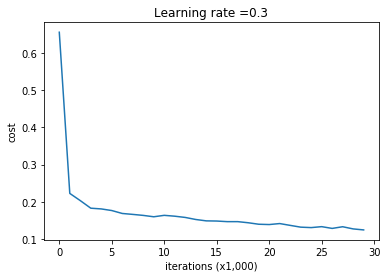

训练集:
Accuracy: 0.9478672985781991
测试集:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y,is_plot=True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

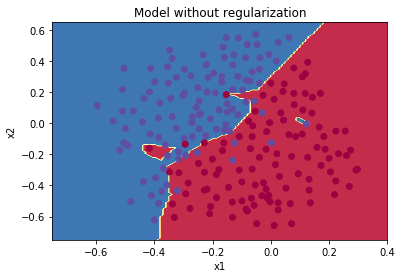

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

从图中可以看出，在无正则化时，分割曲线有了明显的过拟合特性。接下来，我们使用L2正则化：

①使用L2正则化

避免过度拟合的标准方法称为L2正则化，它包括适当修改你的成本函数，我们从原来的成本函数(1)到现在的函数(2)：

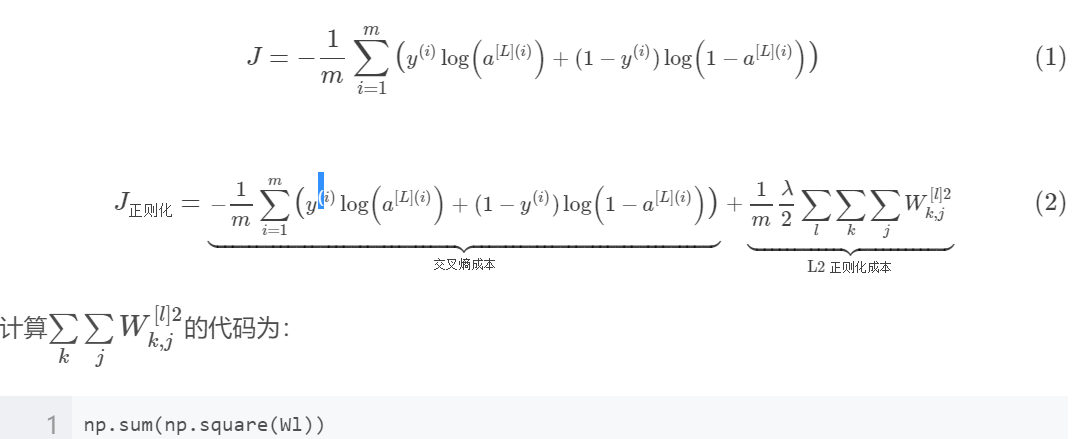

需要注意的是在前向传播中我们对 W[1]W[1], W[2]W[2] 和W[3]W[3]这三个项进行操作，将这三个项相加并乘以 1mλ21mλ2。在后向传播中，使用ddW(12λmW2)=λmWddW(12λmW2)=λmW计算梯度。


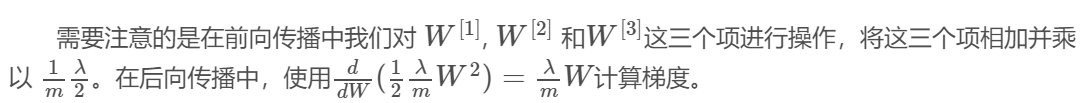

In [6]:
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    """
    实现公式2的L2正则化计算成本

    参数：
        A3 - 正向传播的输出结果，维度为（输出节点数量，训练/测试的数量）
        Y - 标签向量，与数据一一对应，维度为(输出节点数量，训练/测试的数量)
        parameters - 包含模型学习后的参数的字典
    返回：
        cost - 使用公式2计算出来的正则化损失的值

    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = reg_utils.compute_cost(A3,Y)

    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2))  + np.sum(np.square(W3))) / (2 * m)

    cost = cross_entropy_cost + L2_regularization_cost

    return cost

#当然，因为改变了成本函数，我们也必须改变向后传播的函数， 所有的梯度都必须根据这个新的成本值来计算。

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    实现我们添加了L2正则化的模型的后向传播。

    参数：
        X - 输入数据集，维度为（输入节点数量，数据集里面的数量）
        Y - 标签，维度为（输出节点数量，数据集里面的数量）
        cache - 来自forward_propagation（）的cache输出
        lambda - regularization超参数，实数

    返回：
        gradients - 一个包含了每个参数、激活值和预激活值变量的梯度的字典
    """

    m = X.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y

    dW3 = (1 / m) * np.dot(dZ3,A2.T) + ((lambd * W3) / m )
    db3 = (1 / m) * np.sum(dZ3,axis=1,keepdims=True)

    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2,A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)

    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1,X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

第0次迭代，成本值为：0.6974484493131264
第10000次迭代，成本值为：0.2684918873282239
第20000次迭代，成本值为：0.2680916337127301


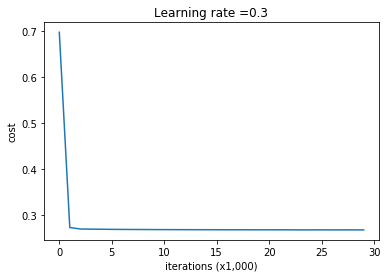

使用正则化，训练集:
Accuracy: 0.9383886255924171
使用正则化，测试集:
Accuracy: 0.93


In [7]:
parameters = model(train_X, train_Y, lambd=0.7,is_plot=True)
print("使用正则化，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用正则化，测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

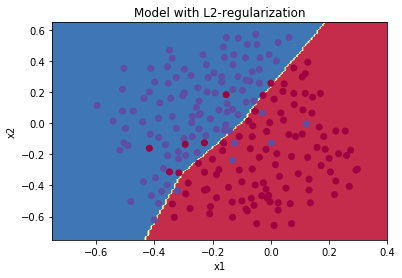

In [8]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

②随机删除节点

 最后，我们使用Dropout来进行正则化，Dropout的原理就是每次迭代过程中随机将其中的一些节点失效。当我们关闭一些节点时，我们实际上修改了我们的模型。背后的想法是，在每次迭代时，我们都会训练一个只使用一部分神经元的不同模型。随着迭代次数的增加，我们的模型的节点会对其他特定节点的激活变得不那么敏感，因为其他节点可能在任何时候会失效

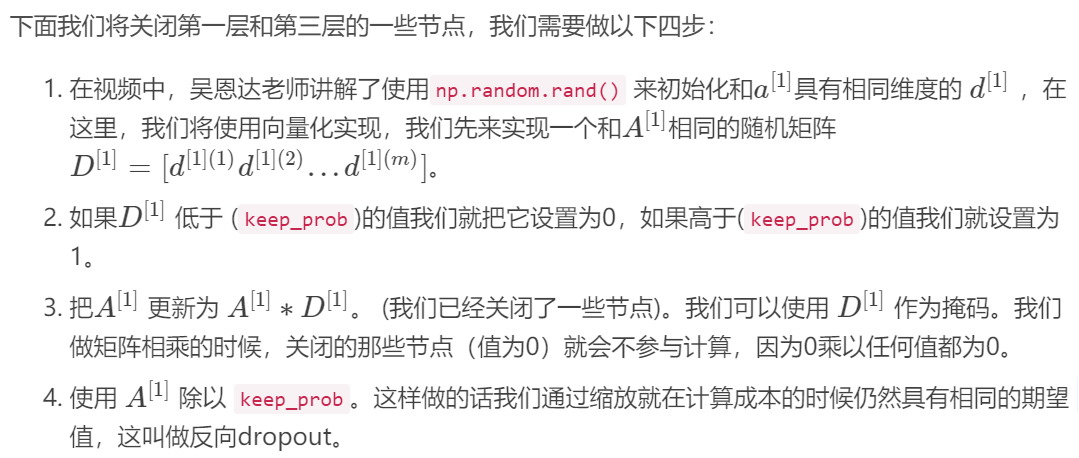

In [9]:
def forward_propagation_with_dropout(X,parameters,keep_prob=0.5):
    """
    实现具有随机舍弃节点的前向传播。
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.

    参数：
        X  - 输入数据集，维度为（2，示例数）
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（20,2）
            b1  - 偏向量，维度为（20,1）
            W2  - 权重矩阵，维度为（3,20）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
        keep_prob  - 随机删除的概率，实数
    返回：
        A3  - 最后的激活值，维度为（1,1），正向传播的输出
        cache - 存储了一些用于计算反向传播的数值的元组
    """
    np.random.seed(1)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    #LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reg_utils.relu(Z1)

    #下面的步骤1-4对应于上述的步骤1-4。
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    #步骤1：初始化矩阵D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             #步骤2：将D1的值转换为0或1（使​​用keep_prob作为阈值）
    A1 = A1 * D1                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A1 = A1 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    """
    #不理解的同学运行一下下面代码就知道了。
    import numpy as np
    np.random.seed(1)
    A1 = np.random.randn(1,3)

    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    keep_prob=0.5
    D1 = D1 < keep_prob
    print(D1)

    A1 = 0.01
    A1 = A1 * D1
    A1 = A1 / keep_prob
    print(A1)
    """

    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)

    #下面的步骤1-4对应于上述的步骤1-4。
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    #步骤1：初始化矩阵D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                             #步骤2：将D2的值转换为0或1（使​​用keep_prob作为阈值）
    A2 = A2 * D2                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A2 = A2 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值

    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

In [10]:
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    """
    实现我们随机删除的模型的后向传播。
    参数：
        X  - 输入数据集，维度为（2，示例数）
        Y  - 标签，维度为（输出节点数量，示例数量）
        cache - 来自forward_propagation_with_dropout（）的cache输出
        keep_prob  - 随机删除的概率，实数

    返回：
        gradients - 一个关于每个参数、激活值和预激活变量的梯度值的字典
    """
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3,A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2 * D2          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA2 = dA2 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA1 = dA1 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

第0次迭代，成本值为：0.6543912405149825


D:\programming\项目\tensorflow\Course 2 - 改善深层神经网络01习题\reg_utils.py:125: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
D:\programming\项目\tensorflow\Course 2 - 改善深层神经网络01习题\reg_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第10000次迭代，成本值为：0.0610169865749056
第20000次迭代，成本值为：0.060582435798513114


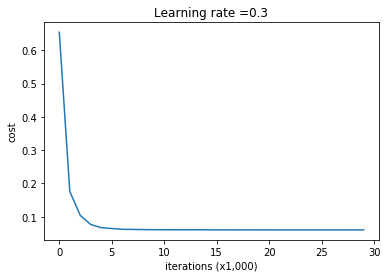

使用随机删除节点，训练集:
Accuracy: 0.9289099526066351
使用随机删除节点，测试集:
Accuracy: 0.95


In [11]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3,is_plot=True)

print("使用随机删除节点，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用随机删除节点，测试集:")
reg_utils.predictions_test = reg_utils.predict(test_X, test_Y, parameters)

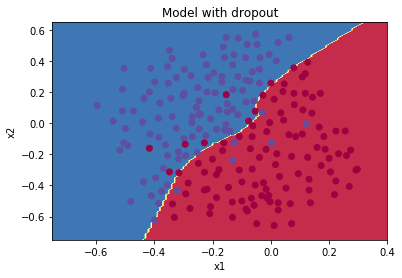

In [12]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)